In [ ]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Set the path to the dataset (change 'My Drive' to the appropriate path)
dataset_path = Path('/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass')

# Example: Loading paths from 'train' directory
train_dir = dataset_path / 'train'
train_images = list(train_dir.glob('*.jpg'))  # Assuming images are .jpg files

test_dir = dataset_path / 'test'
test_images = list(test_dir.glob('*.jpg'))

val_dir = dataset_path / 'valid'
val_images = list(val_dir.glob('*.jpg'))

print("Number of training images:", len(train_images))
print("Number of testing images:", len(test_images))
print("Number of validation images:", len(val_images))


Number of training images: 142
Number of testing images: 20
Number of validation images: 41


In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass/train/_classes.csv")
valid_df = pd.read_csv("/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass/valid/_classes.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass/test/_classes.csv")

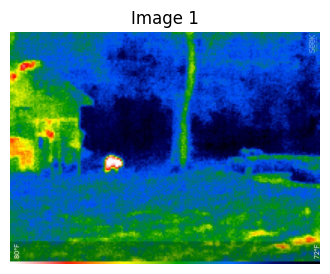

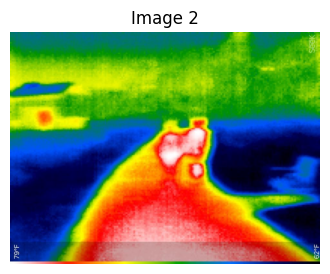

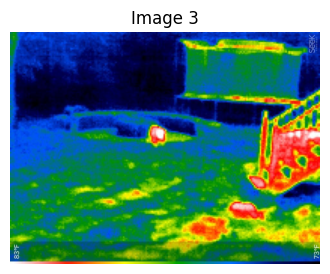

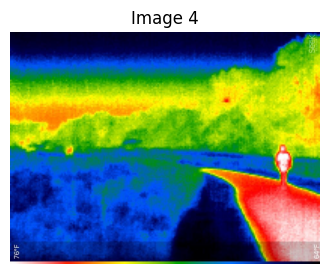

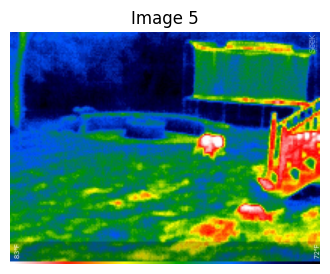

In [ ]:
# Display the first few images in the training set
num_images_to_display = 5
for i, filename in enumerate(train_images[:num_images_to_display]):
    img = Image.open(filename)
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f'Image {i + 1}')
    plt.axis('off')
    plt.show()


In [ ]:
train_df['filename'] = train_df['filename'].apply(lambda x: os.path.join('/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass/train', x))
valid_df['filename'] = valid_df['filename'].apply(lambda x: os.path.join('/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass/valid', x))
test_df['filename'] = test_df['filename'].apply(lambda x: os.path.join('/content/drive/MyDrive/Thermal Dogs and People.v6-raw-images_autoorient.multiclass/test', x))

In [ ]:
train_df.head()

,filename,dog,person
0,/content/drive/MyDrive/Thermal Dogs and People...,1,0
1,/content/drive/MyDrive/Thermal Dogs and People...,1,0
2,/content/drive/MyDrive/Thermal Dogs and People...,1,0
3,/content/drive/MyDrive/Thermal Dogs and People...,1,0
4,/content/drive/MyDrive/Thermal Dogs and People...,1,0


In [ ]:
def load_image_and_label(filename, dog, human):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)  # Change to decode_png for .png files
    image = tf.image.resize(image, [128, 128])  # Resize to match model input size
    image /= 255.0  # Normalize to [0, 1]
    label = tf.convert_to_tensor([dog, human], dtype=tf.float32)  # Multi-label
    return image, label

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['filename'], train_df[' dog'], train_df[' person']))
valid_dataset = tf.data.Dataset.from_tensor_slices((valid_df['filename'], valid_df[' dog'], valid_df[' person']))

In [ ]:
train_dataset = train_dataset.map(lambda x, y1, y2: load_image_and_label(x, y1, y2)).batch(32).shuffle(1000)
valid_dataset = valid_dataset.map(lambda x, y1, y2: load_image_and_label(x, y1, y2)).batch(32)

In [ ]:
def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    """A basic residual block."""
    shortcut = x

    # Apply the shortcut convolution first if necessary
    if conv_shortcut:
        # Use stride in the shortcut convolution to match dimensions
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # First convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adding the shortcut to the output
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x


In [ ]:
def resnet_18(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv and MaxPooling
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual Blocks (layer groups)
    x = resnet_block(x, 64, stride=1, conv_shortcut=False)
    x = resnet_block(x, 64, stride=1, conv_shortcut=False)

    x = resnet_block(x, 128, stride=2, conv_shortcut=True)  # downsample
    x = resnet_block(x, 128, stride=1, conv_shortcut=False)

    x = resnet_block(x, 256, stride=2, conv_shortcut=True)  # downsample
    x = resnet_block(x, 256, stride=1, conv_shortcut=False)

    x = resnet_block(x, 512, stride=2, conv_shortcut=True)  # downsample
    x = resnet_block(x, 512, stride=1, conv_shortcut=False)

    # Average Pooling and Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512)(x)
    x = layers.ReLU()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=x)

    return model

In [ ]:
input_shape = (224, 224, 3)  # ResNet usually works with 224x224 images
num_classes = 2
model = resnet_18(input_shape, num_classes)

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [ ]:
# Assuming dog and person are mutually exclusive and binary (0 or 1)
train_df['label'] = train_df[' dog'].apply(lambda x: '0' if x == 1 else '1') # Convert to strings
valid_df['label'] = valid_df[' dog'].apply(lambda x: '0' if x == 1 else '1') # Convert to strings
test_df['label'] = test_df[' dog'].apply(lambda x: '0' if x == 1 else '1') # Convert to strings


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='train',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory='val',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

model.compile(optimizer='adam',  # Or any other optimizer like 'sgd', 'rmsprop'
              loss='sparse_categorical_crossentropy', # Appropriate for integer labels
              metrics=['accuracy'])
# Train the model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Evaluate the model on the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='test',
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# Evaluate accuracy and print classification score
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on the test set
test_predictions = model.predict(test_generator)
test_predictions_classes = test_predictions.argmax(axis=1)

# Print classification report
print(classification_report(test_generator.classes, test_predictions_classes))

# Manual accuracy calculation
print(f"Manual Accuracy: {accuracy_score(test_generator.classes, test_predictions_classes):.4f}")


Found 142 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 79s 11s/step - accuracy: 0.5241 - loss: 1.8328 - val_accuracy: 0.5366 - val_loss: 15.8602
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 56s 11s/step - accuracy: 0.8028 - loss: 0.6213 - val_accuracy: 0.5366 - val_loss: 47.6658
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 81s 10s/step - accuracy: 0.8415 - loss: 0.3293 - val_accuracy: 0.5366 - val_loss: 115.5868
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 12s/step - accuracy: 0.9429 - loss: 0.2021 - val_accuracy: 0.5366 - val_loss: 55.1191
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 83s 10s/step - accuracy: 0.9112 - loss: 0.1981 - val_accuracy: 0.5366 - val_loss: 54.8914
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 80s 10s/step - accuracy: 0.8929 - loss: 0.1875 - val_accuracy: 0.5366 - val_loss: 28.5935
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 52s 10s/step - accuracy: 0.9377 - loss: 0.1268 - val_accuracy: 0.6098 - val_loss: 14.0611
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 10s/step - accuracy: 0.9270 - loss: 0.1482 - val_accuracy: 0.6829 - val_loss: 11.5345
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8000 - loss: 2.0079
Test Accuracy: 0.8000
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.44      0.44      0.44         9

    accuracy                           0.50        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.50      0.50      0.50        20

Manual Accuracy: 0.5000


In [ ]:
from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def create_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile model
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Models to evaluate
models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'VGG16': VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    'VGG19': VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
}

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Evaluate each model
best_model = None
best_val_accuracy = 0
for name, base_model in models.items():
    print(f"\nTraining model: {name}")
    model = create_model(base_model)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=[early_stopping],
        verbose=1
    )

    # Get the best validation accuracy for this model
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Validation accuracy for {name}: {val_accuracy}")

    # Select the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model

print(f"\nBest model: {best_model} with validation accuracy: {best_val_accuracy}")


Training model: ResNet50
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 193s 27s/step - accuracy: 0.5950 - loss: 1.4051 - val_accuracy: 0.5854 - val_loss: 0.6861
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 196s 27s/step - accuracy: 0.8967 - loss: 0.2787 - val_accuracy: 0.5366 - val_loss: 7.1289
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 136s 30s/step - accuracy: 0.9015 - loss: 0.2251 - val_accuracy: 0.4634 - val_loss: 2.2357
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 138s 27s/step - accuracy: 0.9398 - loss: 0.1909 - val_accuracy: 0.4634 - val_loss: 14.5107
Validation accuracy for ResNet50: 0.5853658318519592

Training model: VGG16
Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 350s 67s/step - accuracy: 0.5385 - loss: 6.8197 - val_accuracy: 0.4634 - val_loss: 1.1366
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 359s 71s/step - accuracy: 0.4917 - loss: 0.8999 - val_accuracy: 0.5366 - val_loss: 0.7439
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 380s 71s/step - accuracy: 0.5967 - loss: 0.6893 - val_accuracy: 0.5366 - val_loss: 0.6923
Validation accu

In [ ]:
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

def resnet_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    shortcut = x
    if conv_shortcut:
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    return x

def build_resnet_18(hp):
    input_shape = (224, 224, 3)
    num_classes = 2

    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # Residual blocks with variable regularization
    regularizer_value = hp.Choice('regularizer_values', [0.0, 0.001, 0.0001])
    if regularizer_value:
        regularizer = tf.keras.regularizers.l2(regularizer_value) # Use l2 regularization
    else:
        regularizer = None

    for filters in [64, 128, 256, 512]:
        conv_shortcut = (filters != 64)
        x = resnet_block(x, filters, stride=2 if conv_shortcut else 1, conv_shortcut=conv_shortcut)
        if regularizer:
            x = layers.Dropout(hp.Float('dropout', 0.1, 0.5, step=0.1))(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, kernel_regularizer=regularizer)(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)

    # Compile model with hyperparameterized optimizer and learning rate
    optimizer = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', [0.01, 0.001, 0.0001])

    if optimizer == 'adam':
        opt = optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    else:
        opt = optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
def get_data_generators():
    # Define a range of augmentation parameters to try
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='train',
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse'
    )
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory='val',
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse'
    )
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        directory='test',
        x_col='filename',
        y_col='label',
        target_size=(224, 224),
        batch_size=32,
        class_mode='sparse'
    )

    return train_generator, val_generator, test_generator


In [ ]:
from keras_tuner import RandomSearch

train_generator, val_generator, test_generator = get_data_generators()

# Initialize the Keras Tuner
tuner = RandomSearch(
    build_resnet_18,
    objective='val_accuracy',
    max_trials=10,  # Adjust number of trials based on computational resources
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='resnet18_tuning'
)

# Search for the best hyperparameters
tuner.search(train_generator, epochs=10, validation_data=val_generator)

# Get the best model and parameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)


Trial 10 Complete [00h 06m 38s]
val_accuracy: 0.5609756112098694

Best val_accuracy So Far: 0.8292682766914368
Total elapsed time: 01h 04m 44s
Best Hyperparameters:
{'regularizer_values': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0001}


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import matplotlib.pyplot as plt

# Define a dictionary to store histories for each trial
history_dict = {}

# Reinitialize Keras Tuner for each combination
tuner = RandomSearch(
    build_resnet_18,
    objective='val_accuracy',
    max_trials=5,  # Adjust the number of trials based on computational resources
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='resnet18_tuning'
)

# Store training histories and best hyperparameters
train_generator, val_generator, test_generator = get_data_generators()

for trial in range(tuner.oracle.max_trials):
    # Perform hyperparameter search for the current trial
    tuner.search(train_generator, epochs=10, validation_data=val_generator)

    # Retrieve best model and best hyperparameters for the current trial
    best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]

    # Train the best model with the best hyperparameters
    history = best_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,  # Number of epochs for each trial
        verbose=1
    )

    # Save history and hyperparameters for this trial
    history_dict[f"Trial_{trial+1}"] = {
        "history": history.history,
        "hyperparameters": best_hyperparameters.values
    }


Reloading Tuner from hyperparam_tuning/resnet18_tuning/tuner0.json
Found 142 validated image filenames belonging to 2 classes.
Found 41 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.7451 - loss: 0.4808 - val_accuracy: 0.4634 - val_loss: 0.7018
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.8700 - loss: 0.3471 - val_accuracy: 0.4634 - val_loss: 0.6976
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.8805 - loss: 0.3031 - val_accuracy: 0.5122 - val_loss: 0.6942
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.8789 - loss: 0.2948 - val_accuracy: 0.5122 - val_loss: 0.6926
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 7s/step - accuracy: 0.9238 - loss: 0.2180 - val_accuracy: 0.4634 - val_loss: 0.6899
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.9376 - loss: 0.1819 - val_accuracy: 0.5366 - val_loss: 0.6888
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.9502 - loss: 0.1957 - val_accuracy: 0.5366 - val_loss: 0.6896
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8974 - loss: 0.2745 - val_accuracy: 0.5366 - val_loss: 0.6867
Epoch 9/10
5/5 ━━━━

Trial_1 - Hyperparameters: {'regularizer_values': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0001}


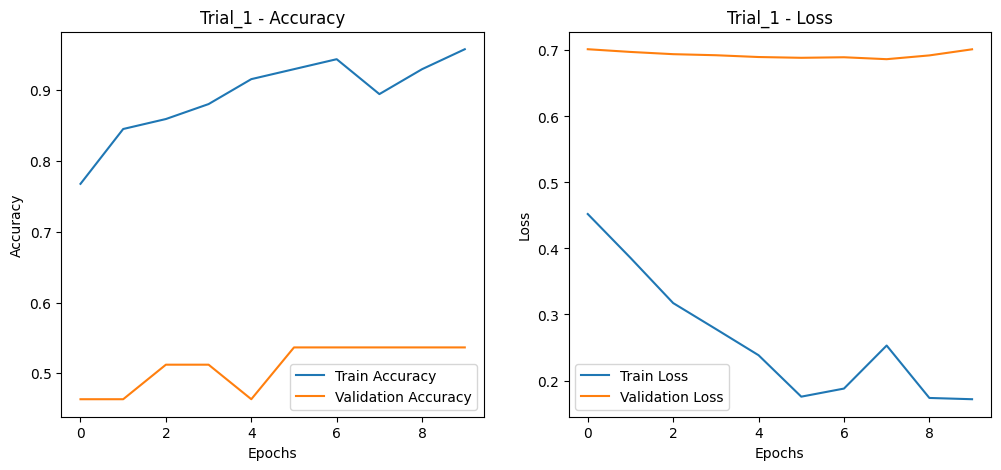

Trial_2 - Hyperparameters: {'regularizer_values': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0001}


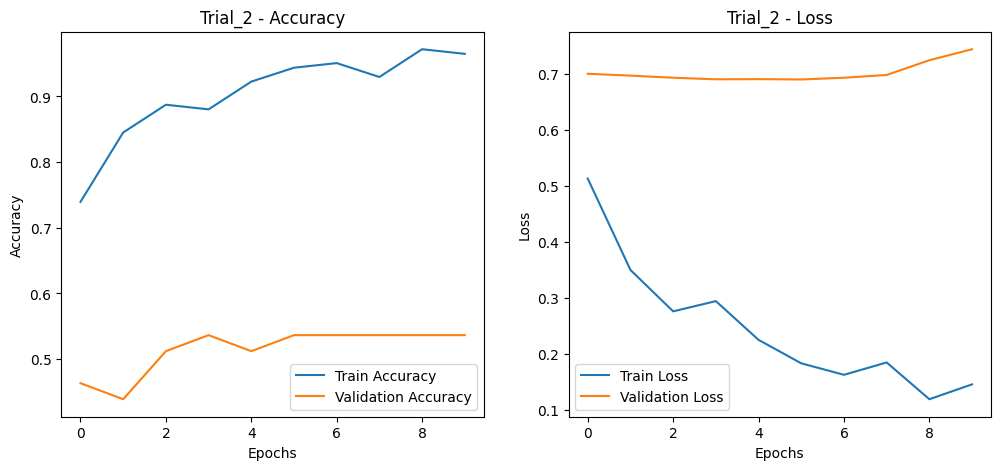

Trial_3 - Hyperparameters: {'regularizer_values': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0001}


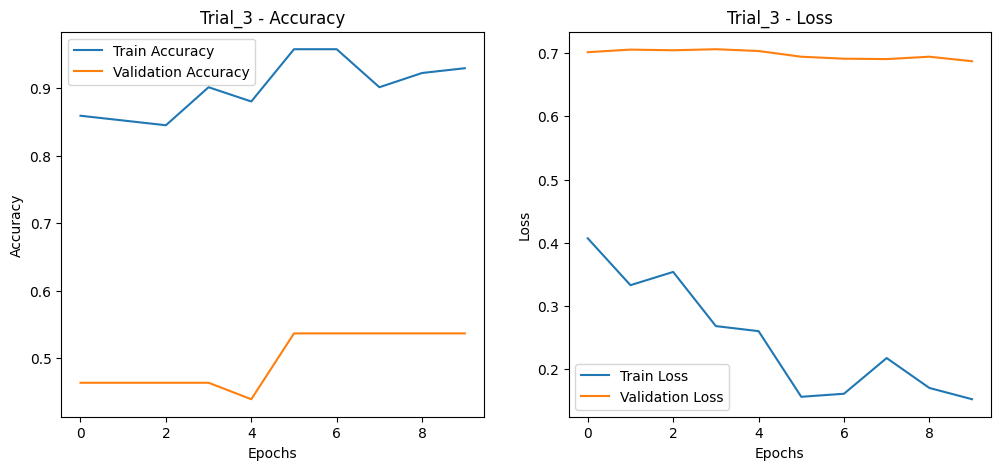

Trial_4 - Hyperparameters: {'regularizer_values': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0001}


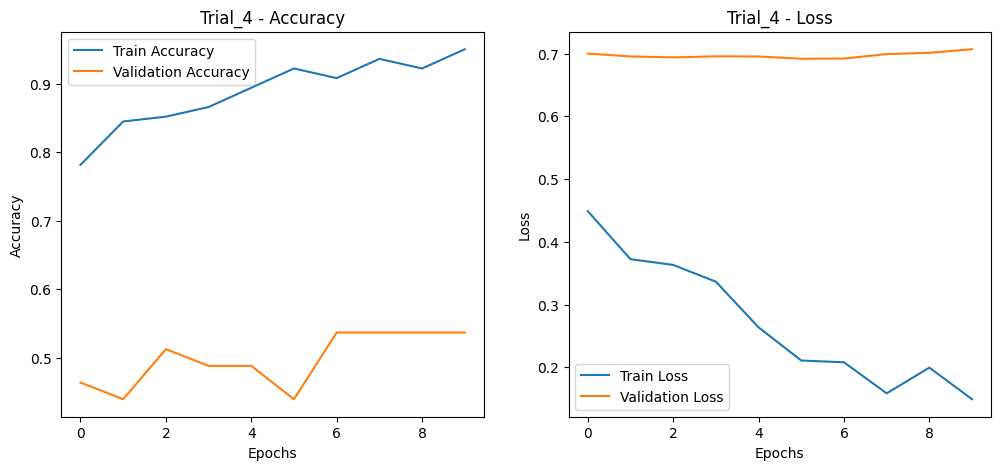

Trial_5 - Hyperparameters: {'regularizer_values': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0001}


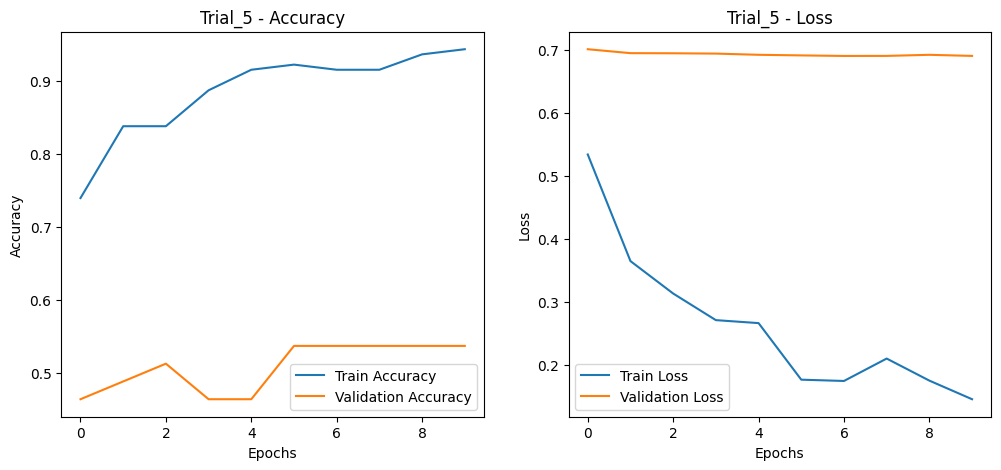

In [ ]:
# Function to plot training and validation metrics
def plot_training_history(history_dict):
    for trial_name, trial_data in history_dict.items():
        history = trial_data["history"]

        # Plot training and validation accuracy
        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"{trial_name} - Accuracy")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
        plt.title(f"{trial_name} - Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Display hyperparameters
        print(f"{trial_name} - Hyperparameters: {trial_data['hyperparameters']}")

        plt.show()

# Plot results
plot_training_history(history_dict)


In [ ]:
# Evaluate the best overall model on the test data
final_best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_acc = final_best_model.evaluate(test_generator)
print(f"Final Test Accuracy: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 106 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7000 - loss: 0.6888
Final Test Accuracy: 0.7000


In [ ]:
print(final_best_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 56, 56, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 128)    │         73,856 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 28, 28, 128)    │            512 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 28, 28, 128)    │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │        147,584 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)    

 Total params: 5,178,114 (19.75 MB)

 Trainable params: 5,172,354 (19.73 MB)

 Non-trainable params: 5,760 (22.50 KB)

None
